In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from preprocessing_modules import create_time_windows_with_labels
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE


/home/nwertheim/miniconda3/bin/python


In [9]:
save_dir = os.path.join(univariate_data_path, "target_univariate.npy")
target_data = np.load(save_dir, allow_pickle=True)
target_data = [item for item in target_data if item['preterm'] is not None]



In [10]:
print(target_data[0])

{'record_name': np.str_('Hopper-2023_05_25_12_03_38-0000010090-0003'), 'signal': array([[-0.70613831],
       [-0.9054771 ],
       [-0.7669727 ],
       ...,
       [-0.4010203 ],
       [-0.44152144],
       [-0.37364218]]), 'fs': 20, 'preterm': 0}


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNHead(nn.Module):
    def __init__(self, input_channels):
        super(CNNHead, self).__init__()
        
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(64, 2)  # Assuming binary classification (output_dim = 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)


class ClassifierWithCNNHead(nn.Module):
    def __init__(self, encoder: nn.Sequential):
        super(ClassifierWithCNNHead, self).__init__()
        self.encoder = encoder  # Pre-trained encoder (frozen externally)
        
        # Determine the encoder output shape
        self.encoder_output_shape = self._get_encoder_output_shape()
        encoder_channels, encoder_length = self.encoder_output_shape

        # CNN classifier head expects (batch, channels, length)
        self.cnn_head = CNNHead(input_channels=encoder_channels)

    def _get_encoder_output_shape(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 12000)
            output = self.encoder(dummy_input)
            return output.shape[1], output.shape[2]  # (channels, length)

    def forward(self, x):
        encoded_features = self.encoder(x)  # (B, C, L)
        output = self.cnn_head(encoded_features)  # (B, 2)
        return output


Balanced class distribution: Counter({0: 625, 1: 625})
Train class distribution: Counter({1: 1070, 0: 506})
Test class distribution: Counter({1: 144, 0: 53})
Epoch [1/10], Train Loss: 0.7637, Test Loss: 0.7465
Epoch [2/10], Train Loss: 0.6812, Test Loss: 0.6777
Epoch [3/10], Train Loss: 0.6358, Test Loss: 0.6382
Epoch [4/10], Train Loss: 0.6252, Test Loss: 0.6253
Epoch [5/10], Train Loss: 0.6145, Test Loss: 0.6167
Epoch [6/10], Train Loss: 0.6080, Test Loss: 0.6134
Epoch [7/10], Train Loss: 0.6118, Test Loss: 0.6227
Epoch [8/10], Train Loss: 0.6102, Test Loss: 0.6105
Epoch [9/10], Train Loss: 0.6031, Test Loss: 0.6162
Epoch [10/10], Train Loss: 0.6015, Test Loss: 0.6177


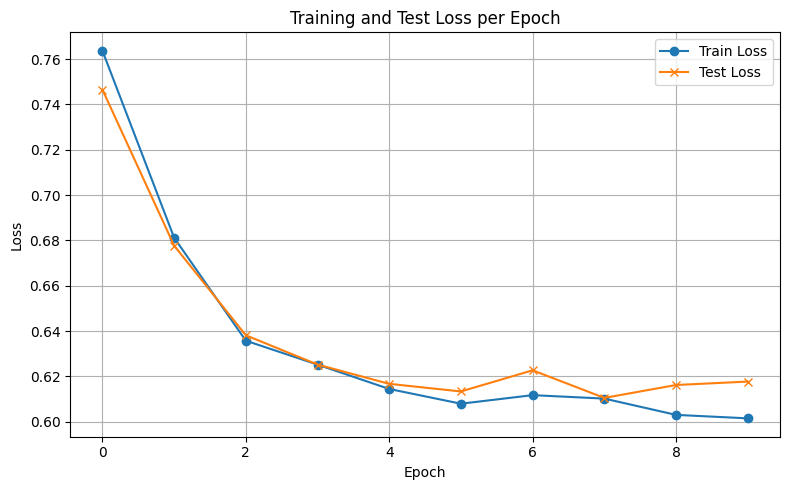

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight



# Example dataset with windows and labels
windows, labels = create_time_windows_with_labels(target_data)

# Convert to tensors
windows_tensor = torch.tensor(windows, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Set random seed
seed = 42
torch.manual_seed(seed)

# Create a full dataset
full_dataset = TensorDataset(windows_tensor, labels_tensor)

# Convert to numpy for easier indexing
windows_np = windows_tensor.numpy()
labels_np = labels_tensor.numpy()

# Find indices of each class
pos_indices = np.where(labels_np == 1)[0]
neg_indices = np.where(labels_np == 0)[0]

# Shuffle to avoid bias
np.random.seed(42)
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)

# Determine the number of samples to match (based on the minority class)
n_samples = min(len(pos_indices), len(neg_indices))

# Undersample both classes to the same size (optional: you can oversample instead if you prefer)
balanced_indices = np.concatenate([pos_indices[:n_samples], neg_indices[:n_samples]])
np.random.shuffle(balanced_indices)  # Shuffle again to mix both classes

# Select the balanced windows and labels
balanced_windows = torch.tensor(windows_np[balanced_indices], dtype=torch.float32)
balanced_labels = torch.tensor(labels_np[balanced_indices], dtype=torch.long)

# Create a balanced dataset
balanced_dataset = TensorDataset(balanced_windows, balanced_labels)

# Check new distribution
from collections import Counter
print("Balanced class distribution:", Counter(balanced_labels.tolist()))

# Calculate lengths for 80-10-10 split
total_len = len(full_dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len  # in case of rounding

# Use generator with seed for reproducibility
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_len, val_len, test_len], generator=generator
)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

from collections import Counter
train_labels = [label.item() for _, label in train_dataset]
test_labels = [label.item() for _, label in test_dataset]
print("Train class distribution:", Counter(train_labels))
print("Test class distribution:", Counter(test_labels))

# Calculate class weights
train_labels = [label.item() for _, label in train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# Load the pre-trained encoder
path = os.path.join(models_path, 'FCMAE_encoder_cpu_5_epochs.pth')

# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, num_blocks=3)

# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False  # Freeze the encoder

# Define the classifier model
model = ClassifierWithCNNHead(encoder)

# Move the model to the device
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # Apply class weights here
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_input, batch_labels in train_loader:
        batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
        batch_input = batch_input.unsqueeze(1)

        optimizer.zero_grad()
        output = model(batch_input)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_input, batch_labels in test_loader:
            batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
            batch_input = batch_input.unsqueeze(1)
            output = model(batch_input)
            loss = criterion(output, batch_labels)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot train vs test loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(test_losses, label="Test Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0     0.2500    0.0377    0.0656        53
           1     0.7302    0.9583    0.8288       144

    accuracy                         0.7107       197
   macro avg     0.4901    0.4980    0.4472       197
weighted avg     0.6010    0.7107    0.6235       197

Accuracy:  0.7107
Precision: 0.7302
Recall:    0.9583
F1 Score:  0.8288
AUC:       0.5605
AP Score:  0.7516


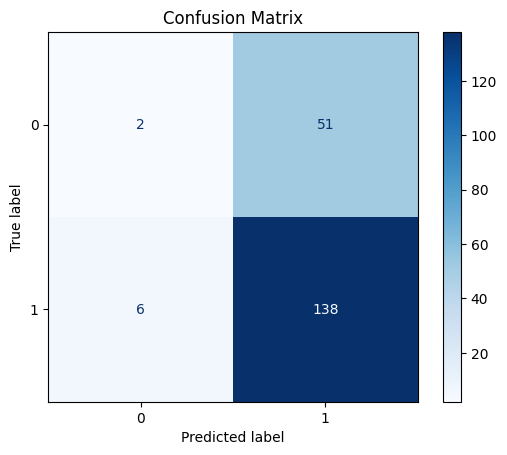

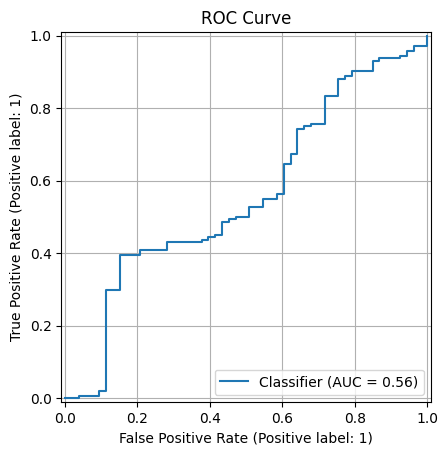

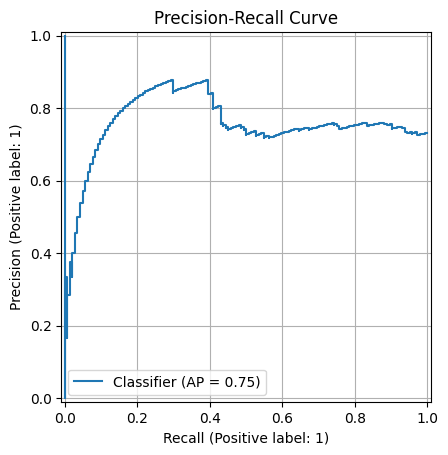

In [13]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import numpy as np

# Evaluation
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for batch_input, batch_labels in test_loader:
        batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
        batch_input = batch_input.unsqueeze(1)
        output = model(batch_input)

        probs = torch.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
        all_targets.extend(batch_labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_targets)
y_pred = np.array(all_preds)
y_score = np.array(all_probs)

# Metrics
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
print(f"AUC:       {roc_auc_score(y_true, y_score):.4f}")
print(f"AP Score:  {average_precision_score(y_true, y_score):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()
